## CLASSIC4 ORIGINAL DATABASE without stemming

### Descarga de la colección de textos del corpus
La estructura de directorios del corpus ha sido ajustada para ser leída por `NLTK`

In [2]:
import os
import classicdb.fetch as fetch

url = "https://sites.google.com/site/xchgdir/public/classic.tar.gz"
classic_home = os.path.join(fetch.get_data_home(), "classic_home")
corpus_root = os.path.join(classic_home, "classic-train")

In [ ]:
print("downloading and extracting file from " + url)
fetch.download_and_unzip(url, classic_home, "classic.tar.gz")
print("downloaded and extracted to " + classic_home)

### Carga del corpus a NLTK

In [29]:
from nltk.corpus import CategorizedPlaintextCorpusReader

print("reading categorized corpus from " + corpus_root)
corpus_reader = CategorizedPlaintextCorpusReader(corpus_root, r'.*', cat_pattern=r'(\w+)/*')
for c in corpus_reader.categories():
    print(corpus_reader.fileids(categories=c)[0:3])

reading categorized corpus from C:\Users\khas.aiur\scikit_learn_data\classic_home\classic-train
['cacm/cacm.000001', 'cacm/cacm.000002', 'cacm/cacm.000003']
['cisi/cisi.000001', 'cisi/cisi.000002', 'cisi/cisi.000003']
['cran/cran.000001', 'cran/cran.000002', 'cran/cran.000003']
['med/med.000001', 'med/med.000002', 'med/med.000003']


### Conteo de tokens del corpus
NLTK's CountVectorizer almacena los contadores en una matriz dispersa CSR (Compressed Sparse Row) `scipy.sparse.csr_matrix`

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

labels = [cat for cat in corpus_reader.categories() for fileid in corpus_reader.fileids(cat)]
file_contents = [corpus_reader.raw(fileid) for fileid in corpus_reader.fileids()]

counter = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1)  
    #tokenizer=
)
count_matrix = counter.fit_transform(file_contents)
vocab = counter.get_feature_names()

print("Count Matrix:", count_matrix.shape)
print(count_matrix.toarray())

print("Count Matrix in CSR form:", count_matrix.shape)
print(count_matrix.tocsr()[0:2])

print("Some feature terms")
print(vocab[0:100])

Count Matrix: (7095, 24542)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
Count Matrix in CSR form: (7095, 24542)
  (0, 17507)	1
  (0, 19106)	1
  (0, 11989)	1
  (0, 1972)	1
  (0, 12812)	1
  (1, 8792)	1
  (1, 19577)	1
  (1, 19075)	1
  (1, 21538)	1
  (1, 7018)	1
  (1, 5260)	1
Some feature terms
['00', '000', '0001', '0005', '000degree', '000degreek', '000g', '000k', '001', '002', '003', '004', '005', '0062', '00675', '008', '00mm', '01', '010', '011', '012', '013', '014', '016', '019', '02', '02025', '021', '0225', '023', '024', '025', '026', '028', '029', '03', '039', '04', '040', '0432', '044', '05', '051', '054', '056', '06', '064', '066', '07', '071', '071182', '073', '077', '08', '084', '087', '088', '09', '0904', '092', '099', '0degree', '0degrees', '10', '100', '1000', '100degrees', '100m', '100x10', '101', '1013', '102', '1021', '1023', '103', '104', '1044', '105', '1050', '1051', '106', '10642', '1

### Cálculo de matriz TFID

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(count_matrix)

print("TFID matrix:", tfidf.shape)
print(tfidf.toarray())
print()

# print("Weights of each feature computed by TFID")
# print(transformer.idf_)

TFID matrix: (7095, 24542)


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]



### Clusterización y evaluación de la clusterización
10 ciclos de k-means para hallar el mejor resultado (300 iteraciones por ciclo)
Evaluación de la efectividad de la clusterización. Ver http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation.
- __Adjusted Rand Index__ [-1, 1] A function that measures the similarity of the two assignments, ignoring permutations. 
- __Mutual Information based scores__ [0, 1] A function that measures the agreement of the two assignments, ignoring permutations. It can be used as a consensus measure.
- __Homogeneity__ [0, 1] Each cluster contains only members of a single class.
- __Completeness__ [0, 1] All members of a given class are assigned to the same cluster.
- __V-measure__ [0, 1] The harmonic mean between homogeneity and completeness.
- __Silhouette Coefficient__ [] A higher Silhouette Coefficient score relates to a model with better defined clusters. a: The mean distance between a sample and all other points in the same class. b: The mean distance between a sample and all other points in the next nearest cluster.
$$s = (b-a)/max(a,b)$$

In [56]:
from sklearn.cluster import KMeans
from sklearn import metrics

km = KMeans(
    n_clusters=len(corpus_reader.categories()),
    init='k-means++',  # or 'random'  
    n_init=100,  # repetition of the process to choose the best
    max_iter=300  # iterations for kmeans
)

print("Document clustering with %s" % km)
km.fit(tfidf)
print()

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(len(corpus_reader.categories())):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % vocab[ind], end='')
    print()

print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Mutual Information based scores: %.3f" % metrics.adjusted_mutual_info_score(labels, km.labels_))
print()

(h, c, v) = metrics.homogeneity_completeness_v_measure(labels, km.labels_)
print("Homogeneity: %0.3f" % h)
print("Completeness: %0.3f" % c)
print("V-measure: %0.3f" % v)
print()

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(tfidf, km.labels_, sample_size=1000))
print()

Document clustering with KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=100,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)



Top terms per cluster:
Cluster 0: computer method language program programming time data problem described paper use presented given systems programs patients analysis problems algol results
Cluster 1: information library retrieval libraries research systems data science scientific use indexing book literature services computer subject document analysis user study
Cluster 2: flow boundary layer pressure mach shock heat supersonic number transfer laminar hypersonic theory body wing surface velocity temperature plate bodies
Cluster 3: algorithm matrix function polynomial d1 complex integration random linear g6 functions a1 integrals s14 real s15 solution integral gamma polynomials
Adjusted Rand-Index: 0.274
Mutual Information based scores: 0.453

Homogeneity: 0.454
Completeness: 0.492
V-measure: 0.472



Silhouette Coefficient: 0.008



### Dendograma

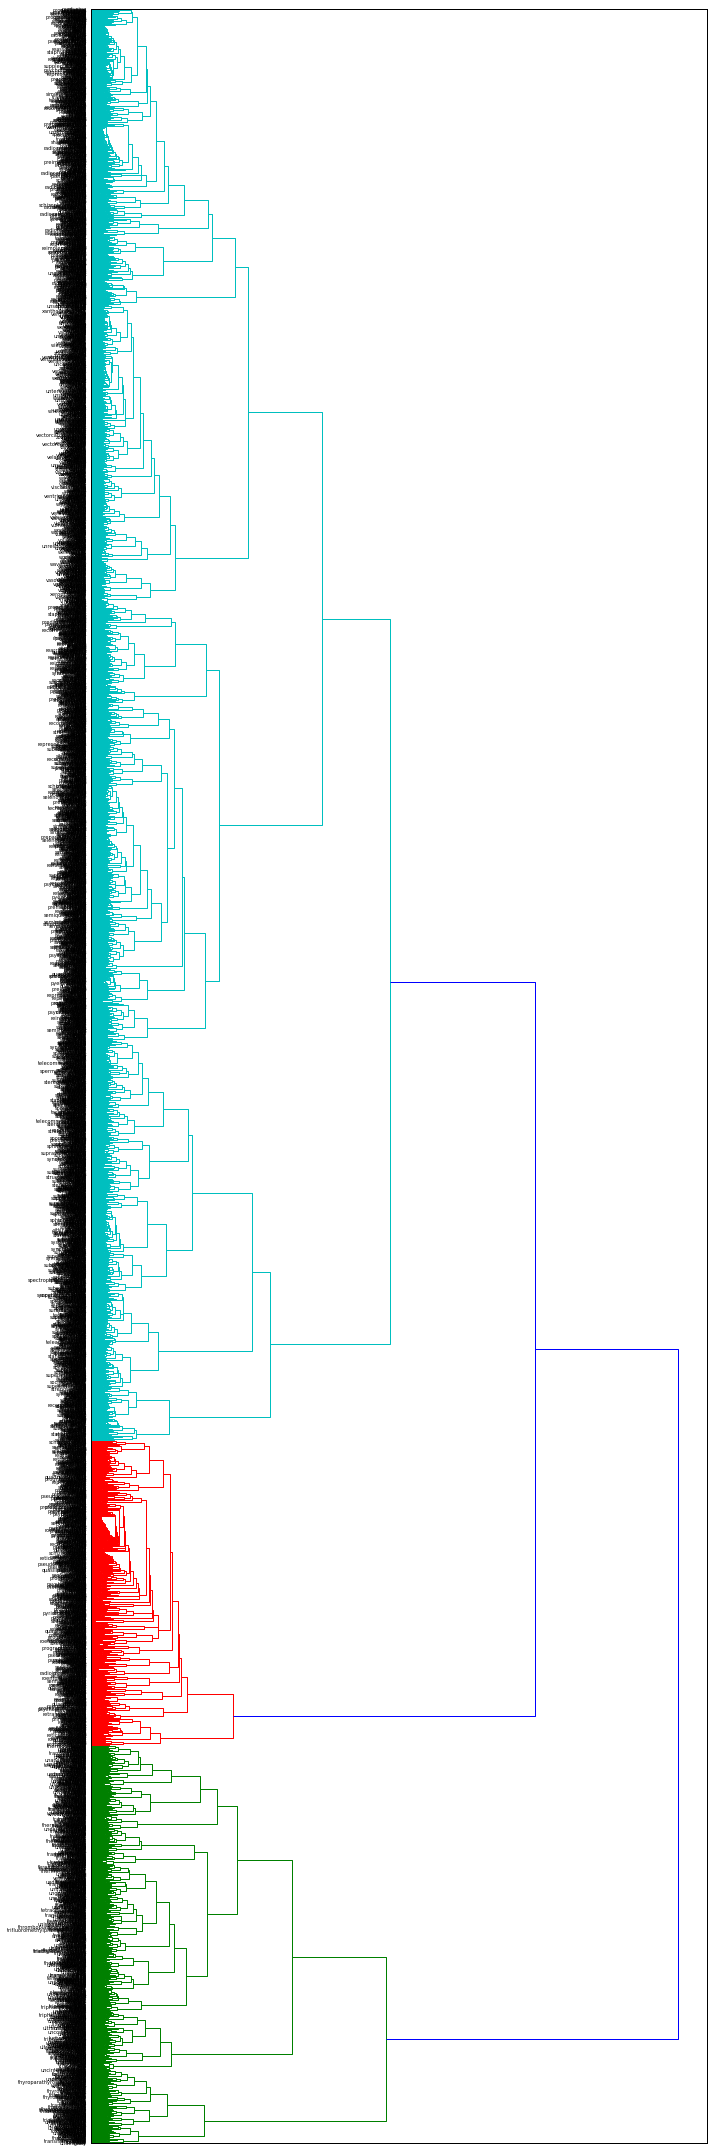

In [55]:
% matplotlib inline

from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

dist = 1 - cosine_similarity(tfidf)
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(10, 30))
ax = dendrogram(linkage_matrix, orientation="right", labels=vocab)
plt.tick_params(
    axis='x',  # changes apply to the x-axis
    which='both',  # both major and minor ticks are affected
    bottom='off',  # ticks along the bottom edge are off
    top='off',  # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout()  #show plot with tight layout